In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
# python version 3.10.11
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go


# import ternary
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from scipy.interpolate import NearestNDInterpolator

from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from matplotlib.colors import ListedColormap
from sklearn.metrics import pairwise_distances

%matplotlib inline


import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt


import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt

# Assuming df_ML is your DataFrame



In [3]:
def generate_mesh(I_range, Br_range, Cl_range):
    """
    Generate a mesh of points for I, Br, and Cl that sum to 1.

    :param I_range: Tuple of (start, end, step) for I.
    :param Br_range: Tuple of (start, end, step) for Br.
    :param Cl_range: Tuple of (start, end, step) for Cl.
    :return: List of [I, Br, Cl] points that sum to 1.
    """
    mesh = []
    I_start, I_end, I_step = I_range
    Br_start, Br_end, Br_step = Br_range
    Cl_start, Cl_end, Cl_step = Cl_range

    I_values = np.linspace(I_start, I_end, round((I_end - I_start) / I_step) + 1)
    Br_values = np.linspace(Br_start, Br_end, round((Br_end - Br_start) / Br_step) + 1)
    Cl_values = np.linspace(Cl_start, Cl_end, round((Cl_end - Cl_start) / Cl_step) + 1)

    for i in I_values:
        for br in Br_values:
            for cl in Cl_values:
                if abs(br + cl + i - 1) < 1e-4:  # Add a small tolerance to deal with floating point precision
                    mesh.append([i, br, cl])

    return mesh



def make_targets(MA_values, mesh_array):
    # Create solutions
    targets = []
    for MA in MA_values:
        for i, br, cl in mesh_array:
            targets.append(make_solution(MA, i, cl))
    return targets


def plot_mesh(mesh_array, color='red', color_values=None, single_point=None, fig=None, symbol='circle', size=5, **marker_kwargs):
    if fig is None:
        fig = go.Figure()

    # Prepare hover text
    hover_text = [f'Color value: {val}' for val in color_values] if color_values is not None else None

    fig.add_trace(go.Scatterternary(
        a=mesh_array[:, 1], b=mesh_array[:, 0], c=mesh_array[:, 2],
        mode='markers',
        marker=dict(color=color_values if color_values is not None else color, size=size, 
                    colorscale='Viridis' if color_values is not None else None, 
                    colorbar=dict(title='Colorbar') if color_values is not None else None, 
                    symbol=symbol, **marker_kwargs),
        text=hover_text  # Add hover text
    ))

    if single_point is not None:
        fig.add_trace(go.Scatterternary(
            a=[single_point[1]], b=[single_point[0]], c=[single_point[2]],
            mode='markers',
            marker=dict(color='red', size=size, symbol=symbol),
            name='Single Point'
        ))

    fig.update_ternaries(aaxis_title="Br", baxis_title="I", caxis_title="Cl")
    fig.update_ternaries(sum=1, baxis_min=.8)
    fig.update_layout({
        'plot_bgcolor': 'white',
        'paper_bgcolor': 'white',
        'ternary': {
            'sum': 1.0,
            'aaxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'baxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'caxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'}
        }
    })

    return fig


def plot_mesh_avg(mesh_array, color='red', color_values=None, single_point=None, fig=None, symbol='circle', size=5, **marker_kwargs):
    if fig is None:
        fig = go.Figure()

    df_mesh = pd.DataFrame(mesh_array, columns=['I', 'Br', 'Cl'])
    if color_values is not None:
        df_mesh['color_values'] = color_values
        df_mesh['compstring'] = df_mesh[['I', 'Br', 'Cl']].astype(str).agg('-'.join, axis=1)
        # Group by 'I', 'Br', 'Cl'
        grouped = df_mesh.groupby(['compstring'])

        # Aggregate color_values: mean if group size > 1, else take the value as is
        df_grouped = grouped.agg(lambda x: x.mean() if len(x) > 1 else x.iloc[0])
        df_grouped.reset_index(inplace=True)
        marker_color = df_grouped['color_values']
    else:
        df_grouped = df_mesh
        marker_color = color

    # Prepare hover text
    hover_text = [f'Color value: {val}' for val in df_grouped['color_values']] if color_values is not None else None

    fig.add_trace(go.Scatterternary(
        a=df_grouped['Br'],
        b=df_grouped['I'],
        c=df_grouped['Cl'],
        mode='markers',
        marker=dict(color=marker_color, size=size, symbol=symbol, 
                    colorscale='Viridis' if color_values is not None else None, 
                    colorbar=dict(title='Colorbar') if color_values is not None else None, 
                    **marker_kwargs),
        text=hover_text  # Add hover text
    ))

    if single_point is not None:
        fig.add_trace(go.Scatterternary(
            a=[single_point[1]], b=[single_point[0]], c=[single_point[2]],
            mode='markers',
            marker=dict(color='red', size=size, symbol=symbol),
            name='Single Point'
        ))

    fig.update_ternaries(aaxis_title="Br", baxis_title="I", caxis_title="Cl")
    fig.update_ternaries(sum=1, baxis_min=.8)
    fig.update_layout({
        'plot_bgcolor': 'white',
        'paper_bgcolor': 'white',
        'ternary': {
            'sum': 1.0,
            'aaxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'baxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'caxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'}
        }
    })

    return fig


def plot_BO_mesh(mesh_array, acq_values, fig=None, symbol='circle', **marker_kwargs):
    # If no figure is provided, create a new one
    if fig is None:
        fig = go.Figure()

    # Add the mesh points to the figure
    fig.add_trace(go.Scatterternary(a=mesh_array[:, 1], b=mesh_array[:, 0], c=mesh_array[:, 2], mode='markers', 
                                    marker=dict(color=acq_values, colorscale='Viridis', symbol=symbol, **marker_kwargs)))

    # Set axis labels
    fig.update_ternaries(aaxis_title="Br", baxis_title="I", caxis_title="Cl")

    # Update axes ranges
    fig.update_ternaries(sum=1, baxis_min=.8)  # update for I axis

    # Change layout options
    fig.update_layout({
        'plot_bgcolor': 'white',  # make plot background white
        'paper_bgcolor': 'white',  # make paper background white
        'ternary': {
            'sum': 1.0,
            'aaxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'baxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'caxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'}
        }
    })

    return fig  # return the updated figure object



def enforce_minimum_distance(ax_client, num_trials, min_distance):
    new_points = []
    trial_indices = []
    while len(new_points) < num_trials:
        # Get a batch of points from the optimizer
        batch_trial_indices, _ = ax_client.get_next_trials(1)
        if not batch_trial_indices:  # If no new trials were generated, break the loop
            break
        for trial_index in batch_trial_indices:
            trial = ax_client.get_trial(trial_index)
            point = trial.arm.parameters
            point_vector = np.array(list(point.values()))  # Convert the point to a vector
            # Check if the point is far enough from all existing points
            if all(np.linalg.norm(point_vector - np.array(list(existing_point.values()))) >= min_distance for existing_point in new_points):
                new_points.append(point)
                trial_indices.append(trial_index)
    return trial_indices


def create_experiment(ax_client, search_parameters, objectives, parameter_constraints):
    ax_client.create_experiment(
        name="moo_experiment",
        parameters=search_parameters,
        objectives=objectives,
        parameter_constraints=parameter_constraints,
        overwrite_existing_experiment=True,
    )

def complete_trials(ax_client, df, standard_errors):
    for _, row in df.iterrows():
        metrics_data = {}
        for metric, standard_error in standard_errors.items():
            if pd.notnull(row[metric]):
                metrics_data[metric] = (row[metric], standard_error)
        if metrics_data:
            trial_parameters = {'I': row['I'], 'Br': row['Br']}
            _, trial_index = ax_client.attach_trial(trial_parameters)
            ax_client.complete_trial(trial_index=trial_index, raw_data=metrics_data)

def create_suggested_samples_df(ax_client, batch_trial_indices):
    suggested_samples = []
    for trial_index in batch_trial_indices:
        trial = ax_client.get_trial(trial_index)
        arm_parameters = trial.arm.parameters
        suggested_samples.append(arm_parameters)
    df_suggested = pd.DataFrame(suggested_samples)
    df_suggested['I'] = df_suggested['I'].round(8)
    df_suggested['Br'] = df_suggested['Br'].round(8)
    df_suggested['Cl'] = 1 - df_suggested['I'] - df_suggested['Br']
    df_suggested.loc[np.isclose(df_suggested['I'] + df_suggested['Br'], 1, atol=1e-8), 'Cl'] = 0
    return df_suggested

def evaluate_acquisition_function(ax_client, search_parameters, metrics, weights):
    model = ax_client.generation_strategy.model
    x_eval = np.linspace(search_parameters[0]['bounds'][0], search_parameters[0]['bounds'][1], 101)
    y_eval = np.linspace(search_parameters[1]['bounds'][0], search_parameters[1]['bounds'][1], 101)
    acq_values = np.zeros((len(x_eval), len(y_eval)))
    metric_names = [metric.name for metric in metrics]
    for i, x in enumerate(x_eval):
        for j, y in enumerate(y_eval):
            if x + y >= 0.95 and x + y <= 1:
                plot_parameters = [ObservationFeatures(parameters={'I': x, 'Br': y})]
                acq_values_dict, _ = model.predict(plot_parameters)
                scalarized_acq_value = 0
                for metric_name, weight in zip(metric_names, weights):
                    acq_value = acq_values_dict[metric_name][0]
                    scalarized_acq_value += weight * acq_value
                acq_values[i, j] = scalarized_acq_value
            else:
                acq_values[i, j] = np.nan
    return acq_values

def get_batch_trial_indices(ax_client, num_trials, min_distance=None):
    if min_distance is not None:
        return enforce_minimum_distance(ax_client, num_trials=num_trials, min_distance=min_distance)
    else:
        trial_indices, _ = ax_client.get_next_trials(num_trials)
        return trial_indices
    
    
def create_mesh_array(search_parameters, num_points=101):
    """
    Create a mesh array from the evaluation points.
    
    Args:
        search_parameters (list[dict]): The search parameters.
        num_points (int, optional): The number of points to evaluate. Defaults to 101.
    
    Returns:
        np.ndarray: The mesh array.
    """
    # Define points at which we'll evaluate the acquisition function
    x_eval = np.linspace(search_parameters[0]['bounds'][0], search_parameters[0]['bounds'][1], num_points)
    y_eval = np.linspace(search_parameters[1]['bounds'][0], search_parameters[1]['bounds'][1], num_points)

    # Create a mesh array from the evaluation points
    mesh_array = np.zeros((len(x_eval), len(y_eval), 3))
    mesh_array[:, :, 0] = x_eval[:, None]
    mesh_array[:, :, 1] = y_eval[None, :]
    mesh_array[:, :, 2] = 1 - x_eval[:, None] - y_eval[None, :]

    return mesh_array


def flatten_mesh_array(mesh_array):
    return mesh_array.reshape(-1, 3), acq_values.flatten()

def plot_acquisition_function(mesh_array_flat, acq_values_flat):
    fig = plot_BO_mesh(mesh_array_flat, acq_values_flat)
    return fig

def plot_data_points(df, df_suggested, fig):
    mesh_array_0 = df[['I', 'Br', 'Cl']].values
    mesh_array_1 = df_suggested[['I', 'Br', 'Cl']].values
    fig = plot_mesh(mesh_array_0, color_values = 'black', fig=fig, size=2)
    fig = plot_mesh(mesh_array_1, color='red',symbol = 'x', fig=fig, size = 5)
    return fig


def complete_trials_and_get_new_df(ax_client, batch_trial_indices, df):
    new_rows = []
    for trial_index in batch_trial_indices:
        trial = ax_client.get_trial(trial_index)
        parameters = trial.arm.parameters
        metric_value = np.random.uniform(low=0.1, high=.5, size=(1,))[0]  # TODO: replace with actual function
        ax_client.complete_trial(trial_index=trial_index, raw_data={'emission_energy_difference': (metric_value, 0.0)})
        parameters['emission_energy_difference'] = metric_value  # store the metric value in the parameters
        new_rows.append(parameters)

    # Append the new rows to the original DataFrame, which will then be fed back into Ax for the next batch
    df_new = pd.DataFrame(new_rows)
    df_new = pd.concat([df, df_new], ignore_index=True)
    df_new['Cl'] = 1 - df_new['I'] - df_new['Br']  # calculate Cl from I and B

    # If I + Br is close to 1 within a tolerance, set Cl to exactly 0
    df_new.loc[np.isclose(df_new['I'] + df_new['Br'], 1, atol=1e-8), 'Cl'] = 0

    return df_new


# def enforce_minimum_distance(ax_client, num_trials, min_distance, max_attempts=100):
#     new_points = []
#     trial_indices = []
#     attempts = 0
#     while len(new_points) < num_trials and attempts < max_attempts:
#         # Get a batch of points from the optimizer
#         batch_trial_indices, _ = ax_client.get_next_trials(1)
#         if not batch_trial_indices:  # If no new trials were generated, break the loop
#             break
#         for trial_index in batch_trial_indices:
#             trial = ax_client.get_trial(trial_index)
#             point = trial.arm.parameters
#             point_vector = np.array(list(point.values()))  # Convert the point to a vector
#             # Check if the point is far enough from all existing points
#             if all(np.linalg.norm(point_vector - np.array(list(existing_point.values()))) >= min_distance for existing_point in new_points):
#                 new_points.append(point)
#                 trial_indices.append(trial_index)
#         attempts += 1
#     return trial_indices



In [4]:
import ternary
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from scipy.interpolate import NearestNDInterpolator
df = pd.DataFrame()
def ternary_heatmap(cols, lims, response, responselabel = None, markerfilter = None, gpr=False, func=np.nanmean, log=False, df=df, colorbar = True, ax=None, label_axes = ['l', 'r', 'b'], **kwargs):
    if responselabel is None:
        responselabel = response
    xraw = df[cols].values
    yraw = df[response].values
    if markerfilter is None:
        mfraw = np.array([True for i in range(xraw.shape[0])])
    else:
        mfraw = df[markerfilter].values
            
    if log:
        yraw = np.log(yraw)
    x = []
    y = []
    mf = []
    for ux in np.unique(xraw, axis=0):
        idx = (xraw == ux).all(axis=1)
        yval = func(yraw[idx])
        
        if not np.isnan(yval):
            y.append(yval)
            x.append(ux)
            mf.append(np.product(mfraw[idx], dtype = bool))
            
    mf = np.array(mf)
#     print(mf)
    # return x
    x = np.array(x)
    # return x
    # x = xraw[idx]
    # y = y[idx]
    x[:,0] = (x[:,0] - lims[0][0])/(lims[0][1] - lims[0][0])
    x[:,1] = (x[:,1] - lims[1][0])/(lims[1][1] - lims[1][0])
    x[:,2] = (x[:,2] - lims[2][0])/(lims[2][1] - lims[2][0])
    interpolator = NearestNDInterpolator(x,y)
    def f(x):
        return interpolator(x)[0] 
    
    ## Boundary and Gridlines
    scale = 40
    if ax is None:
        fig,ax=plt.subplots(figsize=(5,4))
    figure, tax = ternary.figure(ax=ax, scale=scale)

    # Draw Boundary and Gridlines
    tax.boundary(linewidth=0.5)
    tax.gridlines(color="black", multiple=0.2*scale)
    # tax.gridlines(color="blue", multiple=1, linewidth=0.5)

    # Set Axis labels and Title
    fontsize = 20
    # tax.set_title("Simplex Boundary and Gridlines", fontsize=fontsize)
    
    if "l" in label_axes:
#         tax.left_axis_label(cols[2]+'\n', fontsize=18)
        tax.left_corner_label(cols[2], fontsize=20)
    if "b" in label_axes:
#         tax.bottom_axis_label(cols[0]+'\n', fontsize=20)
        tax.right_corner_label(cols[0], fontsize=20)
    if "r" in label_axes:
#         tax.right_axis_label(cols[1]+'\n', fontsize=20)
        tax.top_corner_label(cols[1], fontsize=20)


    
#     tax.right_axis_label(cols[1], fontsize=fontsize)
#     tax.bottom_axis_label(cols[0], fontsize=fontsize)
#     tax.left_axis_label(cols[2], fontsize=fontsize)

    # Set ticks
    ticks = [0.2,0.4,0.6,0.8]
    # ticklocs = [a*scale for a in [0.2,0.4,0.6,0.8]]
    for axis, (lmin, lmax) in zip(['b', 'r', 'l'], lims):
        ticklocs = [a*scale for a in ticks]
        if axis in label_axes:
            ticklabels = [lmin + a*(lmax-lmin) for a in ticks]
        else:
            ticklabels = ['' for a in ticks]
        tax.ticks(axis=axis, linewidth=0.1, ticks=ticklabels, locations=ticklocs, tick_formats='%.2f', offset=0.035)

    # tax.ticks(axis='lbr', 
    if log:
        response += ' (log)'
    if colorbar:
        tax.heatmapf(f, colorbar=True, scientific=False, cbarlabel=responselabel, **kwargs)
    else:
        tax.heatmapf(f, colorbar=False, scientific=False, **kwargs)
#     tax.heatmap(xu.T, yu.T)
    
    idx = mf==True
    if sum(idx)>0:
        tax.scatter(x[mf]*scale, s=10, marker='o', c='k', zorder=10)
    idx = mf==False
    if sum(idx)>0:
        tax.scatter(x[~mf]*scale, s=30, marker='x', color=plt.cm.gray(0.5), zorder=10)

    # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')

    return tax

In [5]:
# python version 3.10.11
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go


%config InlineBackend.figure_format = 'retina'
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['axes.linewidth'] = 1.75 #set the value globally

from ax.core.observation import ObservationFeatures
from ax.core.objective import ScalarizedObjective
from ax.core.optimization_config import OptimizationConfig
from ax.metrics.l2norm import L2NormMetric
from ax.modelbridge.factory import get_GPEI
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep



# python version 3.10.11
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.ticker as ticker
import pickle as pkl
import pandas as pd

from scipy.stats import norm
%config InlineBackend.figure_format = 'retina'
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['axes.linewidth'] = 1.75 #set the value globally



from ax.core.observation import ObservationFeatures
from ax.core.objective import ScalarizedObjective
from ax.core.optimization_config import OptimizationConfig
from ax.metrics.l2norm import L2NormMetric
from ax.modelbridge.factory import get_GPEI
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep


from ax import *
from ax.core import ParameterType, RangeParameter, SearchSpace, OptimizationConfig#, ScalarizedObjective

import pandas as pd
import torch
from ax.metrics.l2norm import L2NormMetric
from ax.modelbridge import get_sobol
from ax.modelbridge.factory import get_GPEI
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models
from ax.service.ax_client import AxClient
from botorch.acquisition import qNegIntegratedPosteriorVariance, qNoisyExpectedImprovement, qUpperConfidenceBound
from botorch.models import SingleTaskGP
from ax.models.torch.botorch_modular.surrogate import Surrogate
from botorch.acquisition.multi_objective.monte_carlo import (
    qExpectedHypervolumeImprovement,
    qNoisyExpectedHypervolumeImprovement, 
)
from botorch.models.gp_regression import FixedNoiseGP


# from botorch.acquisition import qUpperConfidenceBound
from botorch.acquisition.monte_carlo import qUpperConfidenceBound

from botorch.acquisition.input_constructors import acqf_input_constructor


def generate_mesh(I_range, Br_range, Cl_range):
    """
    Generate a mesh of points for I, Br, and Cl that sum to 1.

    :param I_range: Tuple of (start, end, step) for I.
    :param Br_range: Tuple of (start, end, step) for Br.
    :param Cl_range: Tuple of (start, end, step) for Cl.
    :return: List of [I, Br, Cl] points that sum to 1.
    """
    mesh = []
    I_start, I_end, I_step = I_range
    Br_start, Br_end, Br_step = Br_range
    Cl_start, Cl_end, Cl_step = Cl_range

    I_values = np.linspace(I_start, I_end, round((I_end - I_start) / I_step) + 1)
    Br_values = np.linspace(Br_start, Br_end, round((Br_end - Br_start) / Br_step) + 1)
    Cl_values = np.linspace(Cl_start, Cl_end, round((Cl_end - Cl_start) / Cl_step) + 1)

    for i in I_values:
        for br in Br_values:
            for cl in Cl_values:
                if abs(br + cl + i - 1) < 1e-4:  # Add a small tolerance to deal with floating point precision
                    mesh.append([i, br, cl])

    return mesh



def make_targets(MA_values, mesh_array):
    # Create solutions
    targets = []
    for MA in MA_values:
        for i, br, cl in mesh_array:
            targets.append(make_solution(MA, i, cl))
    return targets


def plot_mesh_ml(mesh_array, color='red', color_values=None, fig=None, symbol='circle', size =5, **marker_kwargs):
    # If no figure is provided, create a new one
    if fig is None:
        fig = go.Figure()

    # If color_values is provided, use it to color the points
    if color_values is not None:
        marker_color = color_values
        colorscale = 'Viridis'  # or any other colorscale you prefer
        colorbar = dict(title = 'Colorbar')  # Add a color bar
    else:
        marker_color = color
        colorscale = None
        colorbar = None

    # Add the mesh points to the figure
    fig.add_trace(go.Scatterternary(a=mesh_array[:, 1], b=mesh_array[:, 0], c=mesh_array[:, 2], mode='markers', 
                                    marker=dict(color=marker_color, size= size, colorscale=colorscale, colorbar=colorbar, symbol=symbol, **marker_kwargs)))

    # Set axis labels
    fig.update_ternaries(aaxis_title="Br", baxis_title="I", caxis_title="Cl")

    # Update axes ranges
    fig.update_ternaries(sum=1, baxis_min=.8)  # update for I axis

    # Change layout options
    fig.update_layout({
        'plot_bgcolor': 'white',  # make plot background white
        'paper_bgcolor': 'white',  # make paper background white
        'ternary': {
            'sum': 1.0,
            'aaxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'baxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'caxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'}
        }
    })

    return fig  # return the updated figure object

def plot_mesh_avg(mesh_array, color='red', color_values=None, fig=None, symbol='circle', size=5, **marker_kwargs):
    # If no figure is provided, create a new one
    if fig is None:
        fig = go.Figure()

    # Convert mesh_array to DataFrame for easier manipulation
    df_mesh = pd.DataFrame(mesh_array, columns=['I', 'Br', 'Cl'])
    if color_values is not None:
        df_mesh['color_values'] = color_values

    # Group by the coordinate columns and calculate the mean for the color_values if provided
    if color_values is not None:
        df_grouped = df_mesh.groupby(['I', 'Br', 'Cl'], as_index=False)['color_values'].mean()
        marker_color = df_grouped['color_values']
    else:
        df_grouped = df_mesh
        marker_color = color

    # Add the mesh points to the figure
    fig.add_trace(go.Scatterternary(
        a=df_grouped['Br'],
        b=df_grouped['I'],
        c=df_grouped['Cl'],
        mode='markers',
        marker=dict(
            color=marker_color,
            size=size,
            symbol=symbol,
            colorscale='Viridis' if color_values is not None else None,
            colorbar=dict(title='Colorbar') if color_values is not None else None,
            **marker_kwargs
        )
    ))

    # Set axis labels
    fig.update_ternaries(aaxis_title="Br", baxis_title="I", caxis_title="Cl")

    # Update axes ranges
    # fig.update_ternaries(sum=1)
    
        # Set axis labels
    fig.update_ternaries(aaxis_title="Br", baxis_title="I", caxis_title="Cl")

    # Update axes ranges
    fig.update_ternaries(sum=1, baxis_min=.8)  # update for I axis


    # Change layout options
    fig.update_layout({
        'plot_bgcolor': 'white',
        'paper_bgcolor': 'white',
        'ternary': {
            'sum': 1.0,
            'aaxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'baxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'caxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'}
        }
    })

    return fig  # return the updated figure object


def plot_BO_mesh(mesh_array, acq_values, fig=None, symbol='circle', **marker_kwargs):
    # If no figure is provided, create a new one
    if fig is None:
        fig = go.Figure()

    # Add the mesh points to the figure
    fig.add_trace(go.Scatterternary(a=mesh_array[:, 1], b=mesh_array[:, 0], c=mesh_array[:, 2], mode='markers', 
                                    marker=dict(color=acq_values, colorscale='Viridis', symbol=symbol, **marker_kwargs)))

    # Set axis labels
    fig.update_ternaries(aaxis_title="Br", baxis_title="I", caxis_title="Cl")

    # Update axes ranges
    fig.update_ternaries(sum=1, baxis_min=.8)  # update for I axis

    # Change layout options
    fig.update_layout({
        'plot_bgcolor': 'white',  # make plot background white
        'paper_bgcolor': 'white',  # make paper background white
        'ternary': {
            'sum': 1.0,
            'aaxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'baxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'caxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'}
        }
    })

    return fig  # return the updated figure object



def enforce_minimum_distance(ax_client, num_trials, min_distance):
    new_points = []
    trial_indices = []
    while len(new_points) < num_trials:
        # Get a batch of points from the optimizer
        batch_trial_indices, _ = ax_client.get_next_trials(1)
        if not batch_trial_indices:  # If no new trials were generated, break the loop
            break
        for trial_index in batch_trial_indices:
            trial = ax_client.get_trial(trial_index)
            point = trial.arm.parameters
            point_vector = np.array(list(point.values()))  # Convert the point to a vector
            # Check if the point is far enough from all existing points
            if all(np.linalg.norm(point_vector - np.array(list(existing_point.values()))) >= min_distance for existing_point in new_points):
                new_points.append(point)
                trial_indices.append(trial_index)
    return trial_indices


def create_experiment(ax_client, search_parameters, objectives, parameter_constraints):
    ax_client.create_experiment(
        name="moo_experiment",
        parameters=search_parameters,
        objectives=objectives,
        parameter_constraints=parameter_constraints,
        overwrite_existing_experiment=True,
    )

def complete_trials(ax_client, df, standard_errors):
    for _, row in df.iterrows():
        metrics_data = {}
        for metric, standard_error in standard_errors.items():
            if pd.notnull(row[metric]):
                metrics_data[metric] = (row[metric], standard_error)
        if metrics_data:
            trial_parameters = {'I': row['I'], 'Br': row['Br']}
            _, trial_index = ax_client.attach_trial(trial_parameters)
            ax_client.complete_trial(trial_index=trial_index, raw_data=metrics_data)

def create_suggested_samples_df(ax_client, batch_trial_indices):
    suggested_samples = []
    for trial_index in batch_trial_indices:
        trial = ax_client.get_trial(trial_index)
        arm_parameters = trial.arm.parameters
        suggested_samples.append(arm_parameters)
    df_suggested = pd.DataFrame(suggested_samples)
    df_suggested['I'] = df_suggested['I'].round(8)
    df_suggested['Br'] = df_suggested['Br'].round(8)
    df_suggested['Cl'] = 1 - df_suggested['I'] - df_suggested['Br']
    df_suggested.loc[np.isclose(df_suggested['I'] + df_suggested['Br'], 1, atol=1e-8), 'Cl'] = 0
    return df_suggested

def evaluate_acquisition_function(ax_client, search_parameters, metrics, weights):
    model = ax_client.generation_strategy.model
    x_eval = np.linspace(search_parameters[0]['bounds'][0], search_parameters[0]['bounds'][1], 101)
    y_eval = np.linspace(search_parameters[1]['bounds'][0], search_parameters[1]['bounds'][1], 101)
    acq_values = np.zeros((len(x_eval), len(y_eval)))
    metric_names = [metric.name for metric in metrics]
    for i, x in enumerate(x_eval):
        for j, y in enumerate(y_eval):
            if x + y >= 0.95 and x + y <= 1:
                plot_parameters = [ObservationFeatures(parameters={'I': x, 'Br': y})]
                acq_values_dict, _ = model.predict(plot_parameters)
                scalarized_acq_value = 0
                for metric_name, weight in zip(metric_names, weights):
                    acq_value = acq_values_dict[metric_name][0]
                    scalarized_acq_value += weight * acq_value
                acq_values[i, j] = scalarized_acq_value
            else:
                acq_values[i, j] = np.nan
    return acq_values

def get_batch_trial_indices(ax_client, num_trials, min_distance=None):
    if min_distance is not None:
        return enforce_minimum_distance(ax_client, num_trials=num_trials, min_distance=min_distance)
    else:
        trial_indices, _ = ax_client.get_next_trials(num_trials)
        return trial_indices
    
    
def create_mesh_array(search_parameters, num_points=101):
    """
    Create a mesh array from the evaluation points.
    
    Args:
        search_parameters (list[dict]): The search parameters.
        num_points (int, optional): The number of points to evaluate. Defaults to 101.
    
    Returns:
        np.ndarray: The mesh array.
    """
    # Define points at which we'll evaluate the acquisition function
    x_eval = np.linspace(search_parameters[0]['bounds'][0], search_parameters[0]['bounds'][1], num_points)
    y_eval = np.linspace(search_parameters[1]['bounds'][0], search_parameters[1]['bounds'][1], num_points)

    # Create a mesh array from the evaluation points
    mesh_array = np.zeros((len(x_eval), len(y_eval), 3))
    mesh_array[:, :, 0] = x_eval[:, None]
    mesh_array[:, :, 1] = y_eval[None, :]
    mesh_array[:, :, 2] = 1 - x_eval[:, None] - y_eval[None, :]

    return mesh_array


def flatten_mesh_array(mesh_array):
    return mesh_array.reshape(-1, 3), acq_values.flatten()

def plot_acquisition_function(mesh_array_flat, acq_values_flat):
    fig = plot_BO_mesh(mesh_array_flat, acq_values_flat)
    return fig

def plot_data_points(df, df_suggested, fig):
    mesh_array_0 = df[['I', 'Br', 'Cl']].values
    mesh_array_1 = df_suggested[['I', 'Br', 'Cl']].values
    fig = plot_mesh(mesh_array_0, color_values = 'black', fig=fig, size=2)
    fig = plot_mesh(mesh_array_1, color='red',symbol = 'x', fig=fig, size = 5)
    return fig


def complete_trials_and_get_new_df(ax_client, batch_trial_indices, df):
    new_rows = []
    for trial_index in batch_trial_indices:
        trial = ax_client.get_trial(trial_index)
        parameters = trial.arm.parameters
        metric_value = np.random.uniform(low=0.1, high=.5, size=(1,))[0]  # TODO: replace with actual function
        ax_client.complete_trial(trial_index=trial_index, raw_data={'emission_energy_difference': (metric_value, 0.0)})
        parameters['emission_energy_difference'] = metric_value  # store the metric value in the parameters
        new_rows.append(parameters)

    # Append the new rows to the original DataFrame, which will then be fed back into Ax for the next batch
    df_new = pd.DataFrame(new_rows)
    df_new = pd.concat([df, df_new], ignore_index=True)
    df_new['Cl'] = 1 - df_new['I'] - df_new['Br']  # calculate Cl from I and B

    # If I + Br is close to 1 within a tolerance, set Cl to exactly 0
    df_new.loc[np.isclose(df_new['I'] + df_new['Br'], 1, atol=1e-8), 'Cl'] = 0

    return df_new


# def enforce_minimum_distance(ax_client, num_trials, min_distance, max_attempts=100):
#     new_points = []
#     trial_indices = []
#     attempts = 0
#     while len(new_points) < num_trials and attempts < max_attempts:
#         # Get a batch of points from the optimizer
#         batch_trial_indices, _ = ax_client.get_next_trials(1)
#         if not batch_trial_indices:  # If no new trials were generated, break the loop
#             break
#         for trial_index in batch_trial_indices:
#             trial = ax_client.get_trial(trial_index)
#             point = trial.arm.parameters
#             point_vector = np.array(list(point.values()))  # Convert the point to a vector
#             # Check if the point is far enough from all existing points
#             if all(np.linalg.norm(point_vector - np.array(list(existing_point.values()))) >= min_distance for existing_point in new_points):
#                 new_points.append(point)
#                 trial_indices.append(trial_index)
#         attempts += 1
#     return trial_indices



In [6]:
def plot_three_prePS(response, df,  **kwargs):
    fig, ax = plt.subplots(1,3,figsize=(10.5,3))
    for ax_, MA, label_axes, cb in zip(
        ax, 
        [0, 0.05, 0.1], 
        [["l", "b"], [], ["r"]],
        [False, False, False],
    ):
        dfsel = df[df['MA'] == MA]
        
        tax = ternary_heatmap(
            ['Cl', 'Br', 'I'],
            [
                (0,0.2),
                (0, 0.2),
                (0.8, 1.0)
            ],
            response,
            func=np.nanmean,
            gpr=False,
            ax=ax_,
            df=dfsel,
            label_axes=label_axes,
            colorbar=False,
            **kwargs
            )
#         ax_[0].set_title(f'MA = {MA}')
    return fig, ax

In [7]:
def plot_three_error(response, df, **kwargs):
    fig, ax = plt.subplots(2,3,figsize=(12.5,6))
    for ax_, MA in zip(ax.T, [0, 0.05, 0.1]):
        dfsel = df[df['MA'] == MA]
        

        tax = ternary_heatmap(
            ['Cl', 'Br', 'I'],
            [
                (0,0.2),
                (0, 0.2),
                (0.8, 1.0)
            ],
            response,
            func=np.nanmean,
            gpr=False,
            ax=ax_[0],
            df=dfsel,
            **kwargs
            )

        tax = ternary_heatmap(
            ['Cl', 'Br', 'I'],
            [
                (0,0.2),
                (0, 0.2),
                (0.8, 1.0)
            ],
            response,
            cmap=plt.cm.viridis,
            func=np.nanstd,
            gpr=False,
        #     log=True,
        #     vmin=1.58,
        #     vmax=1.67,
            df=dfsel,
            ax=ax_[1]
            )
#         ax_[0].set_title(f'MA = {MA}')

In [8]:
def plot_three(response, df,  **kwargs):
    fig, ax = plt.subplots(1,3,figsize=(12.5,3))
    for ax_, MA in zip(ax, [0, 0.05, 0.1]):
        dfsel = df[df['MA'] == MA]
        
        tax = ternary_heatmap(
            ['Cl', 'Br', 'I'],
            [
                (0,0.2),
                (0, 0.2),
                (0.8, 1.0)
            ],
            response,
            func=np.nanmean,
            gpr=False,
            ax=ax_,
            df=dfsel,
            **kwargs
            )
        fig.show()
    return fig, ax
#         ax_[0].set_title(f'MA = {MA}')

In [9]:
def plot_three_prePS(response, df,  **kwargs):
    fig, ax = plt.subplots(1,3,figsize=(10.5,3))
    for ax_, MA, label_axes, cb in zip(
        ax, 
        [0, 0.05, 0.1], 
        [["l", "b"], [], ["r"]],
        [False, False, False],
    ):
        dfsel = df[df['MA'] == MA]
        
        tax = ternary_heatmap(
            ['Cl', 'Br', 'I'],
            [
                (0,0.2),
                (0, 0.2),
                (0.8, 1.0)
            ],
            response,
            func=np.nanmean,
            gpr=False,
            ax=ax_,
            df=dfsel,
            label_axes=label_axes,
            colorbar=False,
            **kwargs
            )
#         ax_[0].set_title(f'MA = {MA}')
    return fig, ax

# Gather Data


## BODP4T Dataset

In [10]:
df_bodp4t = pd.read_pickle('E:\SynologyDrive\BODP4T\PASCAL_analysis\PASCAL_metrics_pkl\BODP4T_allgrid_combined_dataframe.pkl')

In [12]:
# Create a dictionary for renaming columns

rename_dict = {
    'K_mean_delta': 'K_delta',
    'K_delta_mean': 'K_delta',
    'ps_intensity_rate_0_mean' : 'ps_intensity_rate_0',
    'pl_intensity_0_mean' : 'redplspec_intensity',
    'pl_peakev_0_mean' : 'redplspec_peakev',
    'pl_fwhm_0_mean' : 'redplspec_fwhm',
    'ps_intensity_scale_0_mean' : 'photo_intensityshift',
    'ps_peakev_delta_0_mean' : 'photo_colorshift',
    'ps_peakev_rate_0_mean' : 'ps_peakev_rate_0',
    't_bandgap_0_mean' : 't_bandgap_0',
    'df_median_0_mean' : 'df_median_0',
    
    'ps_intensity_rate_0' : 'ps_intensity_rate_0',
    'pl_intensity_0' : 'redplspec_intensity',
    'pl_peakev_0' : 'redplspec_peakev',
    'pl_fwhm_0' : 'redplspec_fwhm',
    'ps_intensity_scale_0' : 'photo_intensityshift',
    'ps_peakev_delta_0' : 'photo_colorshift',
    'ps_peakev_rate_0' : 'ps_peakev_rate_0',
    't_bandgap_0' : 't_bandgap_0',
    'df_median_0' : 'df_median_0',


    
    
    # 'delta_plpeakev': 'thermal_colorshift',
    # 'photostability_peakev_delta': 'photo_colorshift'
}

# Rename the columns
df_bodp4t = df_bodp4t.rename(columns=rename_dict)
# df_bodp4t_r1 = df_bodp4t_r1.rename(columns=rename_dict)

# Display the DataFrame to confirm the changes
print(df_bodp4t.columns)

# print(df_bodp4t_r1.columns)


Index(['Unnamed: 0', 'name', 'storage_tray', 'storage_slot', 'substrate',
       'worklist', 'spincoat0_drop0_time', 'spincoat0_drop0_height',
       'spincoat0_drop0_rate', 'spincoat0_drop0_volume',
       'spincoat0_drop0_molarity', 'spincoat0_drop0_solutes',
       'spincoat0_drop0_solutes_dict', 'spincoat0_drop0_solvent',
       'spincoat0_drop0_solvent_dict', 'spincoat0_drop1_time',
       'spincoat0_drop1_height', 'spincoat0_drop1_rate',
       'spincoat0_drop1_volume', 'spincoat0_drop1_molarity',
       'spincoat0_drop1_solutes', 'spincoat0_drop1_solutes_dict',
       'spincoat0_drop1_solvent', 'spincoat0_drop1_solvent_dict',
       'redplspec_intensity', 'redplspec_peakev', 'redplspec_fwhm',
       'photo_intensityshift', 'ps_intensity_rate_0', 'photo_colorshift',
       'ps_peakev_rate_0', 't_bandgap_0', 't_samplepresent_0', 'df_median_0',
       'bf_inhomogeneity_0', 'name.1', 'sample', 'spincoat', 'spincoat0',
       'spincoat1', 'name.2', 'batch', 'I_frac', 'Br_frac', 'Cl_f

In [16]:
df_bodp4t['exp'] = 'BODP4T'
# df_wbg['exp'] = 'WBG'

In [18]:
# Combine the two 'photo_colorshift' columns into one new column 'photo_colorshift1'
# This assumes df_bodp4t has two columns named 'photo_colorshift', differentiated by their position.
df_bodp4t['photo_colorshift1'] = df_bodp4t.iloc[:, df_bodp4t.columns.get_loc('photo_colorshift')].bfill(axis=1).iloc[:, 0]

## Drop the original 'photo_colorshift' columns
# Since they're identically named, we use a workaround by dropping all but the newly created 'photo_colorshift1'
df_bodp4t = df_bodp4t.loc[:, ~df_bodp4t.columns.duplicated(keep=False)]  # Drop all duplicated columns first
df_bodp4t.drop(columns=['photo_colorshift'], errors='ignore', inplace=True)  # Then attempt to drop 'photo_colorshift' if still exists

# Rename 'photo_colorshift1' back to 'photo_colorshift'
df_bodp4t.rename(columns={'photo_colorshift1': 'photo_colorshift'}, inplace=True)

# Display the DataFrame to confirm the changes
df_bodp4t.head()



,Unnamed: 0,name,storage_tray,storage_slot,substrate,worklist,spincoat0_drop0_time,spincoat0_drop0_height,spincoat0_drop0_rate,spincoat0_drop0_volume,...,df_median_0_count,I_frac_count,Br_frac_count,Cl_frac_count,K_delta_count,K_delta_negative,placeholder,NumericLabel,exp,photo_colorshift
0,0.0,sample0,Tray2,A1,glass,"[{""name"": ""spincoat"", ""start"": NaN, ""id"": ""spi...",-5.0,2.0,80.0,40.0,...,NaN,NaN,NaN,NaN,NaN,-0.223831,1,0,BODP4T,-0.004738
1,1.0,sample1,Tray2,A2,glass,"[{""name"": ""spincoat"", ""start"": NaN, ""id"": ""spi...",-5.0,2.0,80.0,40.0,...,NaN,NaN,NaN,NaN,NaN,-0.279810,1,0,BODP4T,-0.009722
2,2.0,sample2,Tray2,A3,glass,"[{""name"": ""spincoat"", ""start"": NaN, ""id"": ""spi...",-5.0,2.0,80.0,40.0,...,NaN,NaN,NaN,NaN,NaN,-0.296698,1,0,BODP4T,0.006553
3,3.0,sample3,Tray2,A4,glass,"[{""name"": ""spincoat"", ""start"": NaN, ""id"": ""spi...",-5.0,2.0,80.0,40.0,...,NaN,NaN,NaN,NaN,NaN,-0.221326,1,0,BODP4T,-0.002352
4,4.0,sample4,Tray2,A5,glass,"[{""name"": ""spincoat"", ""start"": NaN, ""id"": ""spi...",-5.0,2.0,80.0,40.0,...,NaN,NaN,NaN,NaN,NaN,-0.260027,1,0,BODP4T,-0.008267


In [19]:
# df_ML = pd.concat([df_bodp4t,df_wbg], ignore_index=True, axis=0)
df_ML = df_bodp4t

In [21]:


df_ML['Br_x_photo_colorshift'] = df_ML['Br']*df_ML['photo_colorshift']
df_ML['I_x_photo_colorshift'] = df_ML['I']*df_ML['photo_colorshift']
df_ML['Cl_x_photo_colorshift'] = df_ML['Cl']*df_ML['photo_colorshift']

df_ML['Br_x_peakev'] = df_ML['Br']*df_ML['redplspec_peakev']
df_ML['I_x_peakev'] = df_ML['I']*df_ML['redplspec_peakev']
df_ML['Cl_x_peakev'] = df_ML['Cl']*df_ML['redplspec_peakev']

df_ML['Br_x_fwhm'] = df_ML['Br']*df_ML['redplspec_fwhm']
df_ML['I_x_fwhm'] = df_ML['I']*df_ML['redplspec_fwhm']
df_ML['Cl_x_fwhm'] = df_ML['Cl']*df_ML['redplspec_fwhm']


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


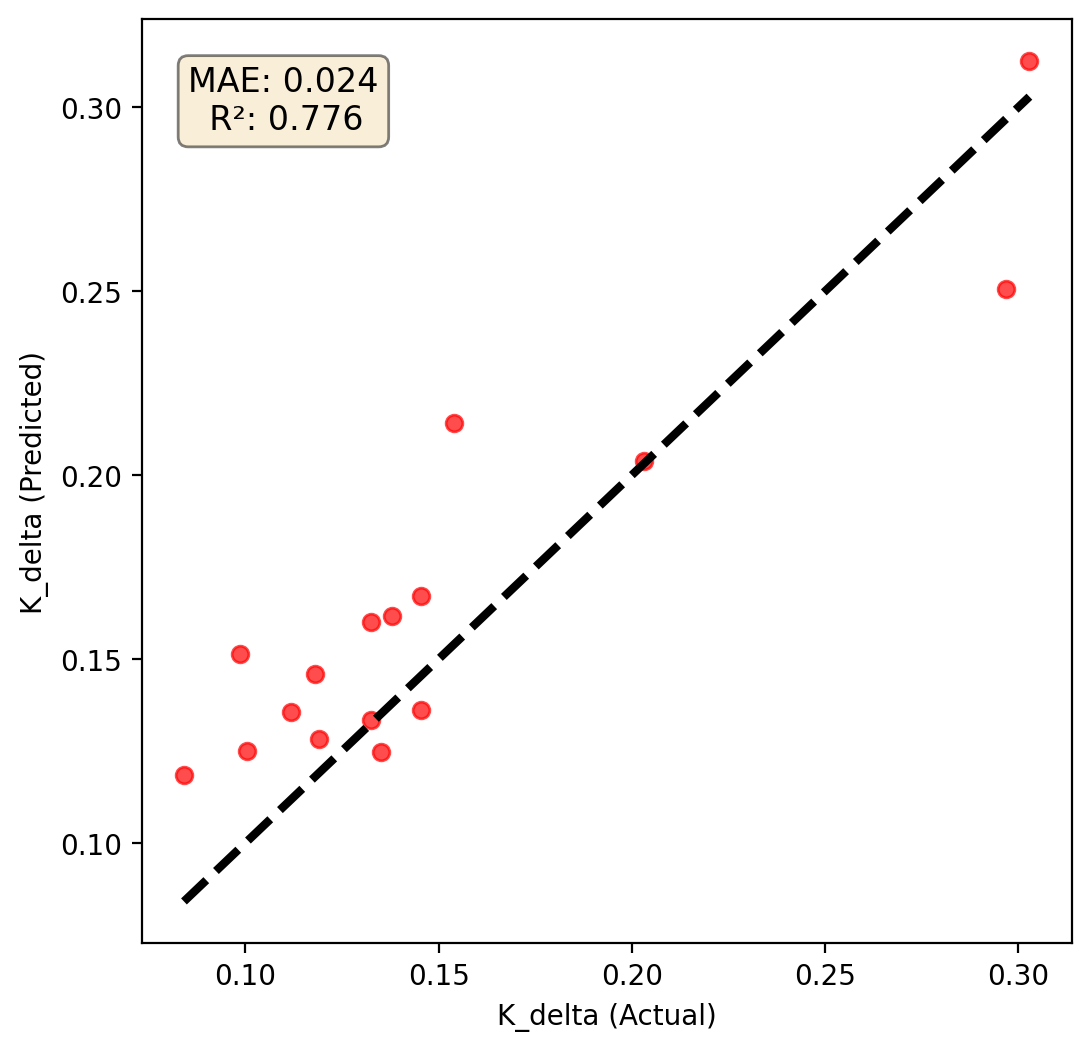

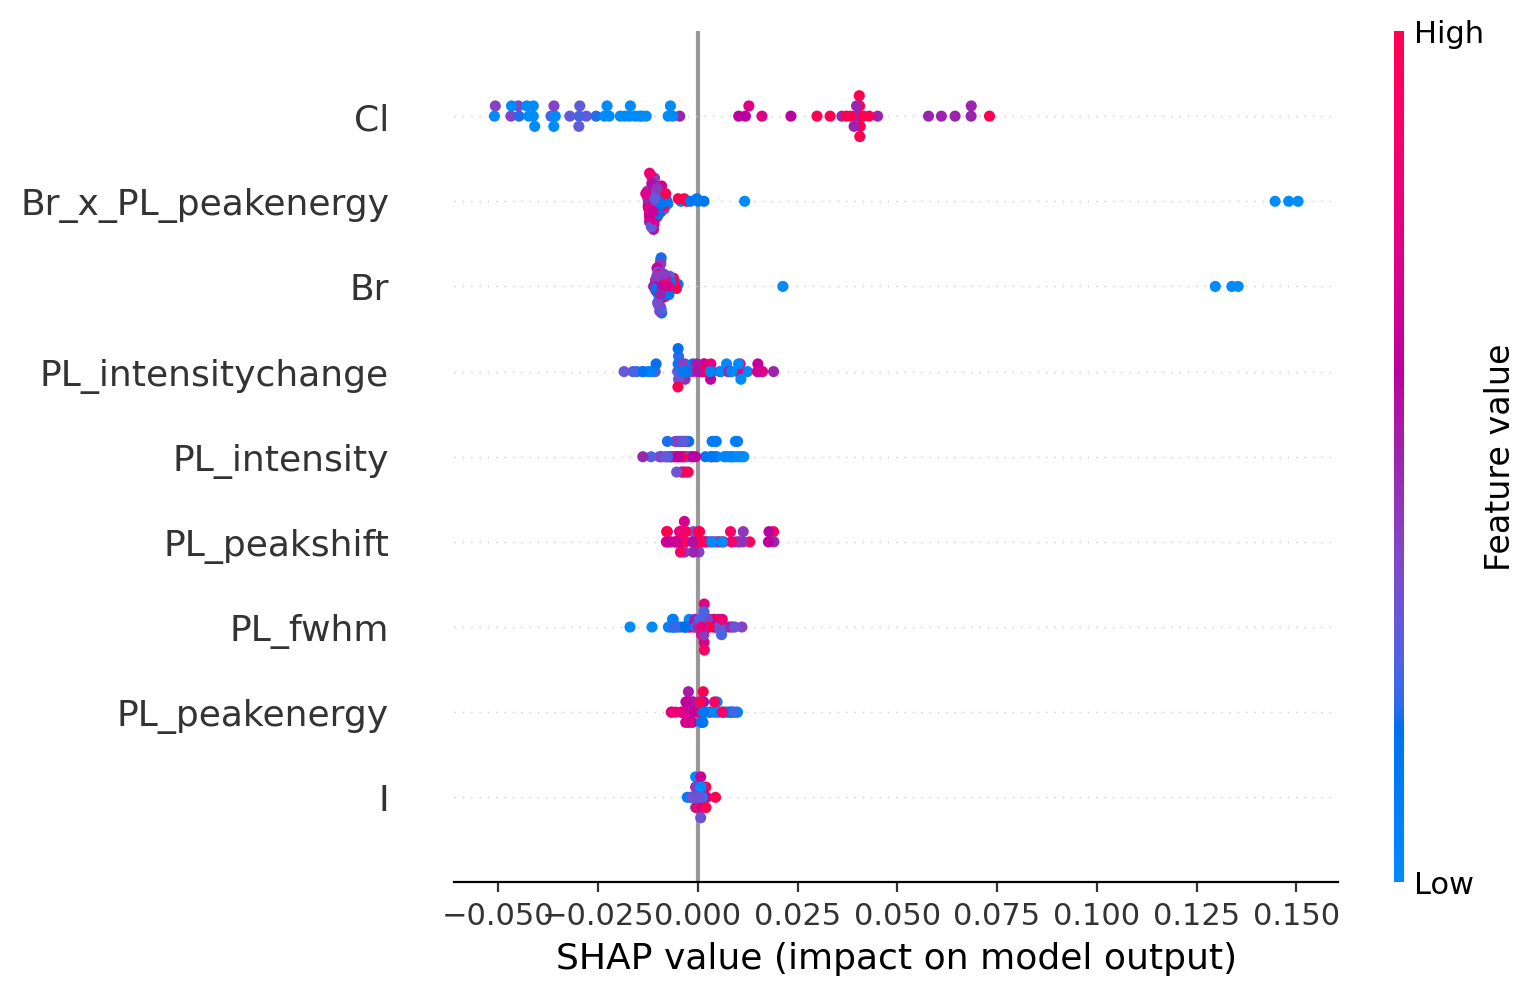

In [22]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#EXAMPLE SINGLE RUN
random_state = 1401


# Define the parameter grid to search
# param_grid = {
#     'n_estimators': [500],  # Number of trees in the forest
#     'max_depth': [None, 2, 3, 5, 7, 10, 20, 30, 40],  # Maximum depth of the tree
#     'min_samples_split': [2,3,4, 5, 10],  # Minimum number of samples required to split a node
#     'min_samples_leaf': [1,2,3, 4],     # Minimum number of samples required at each leaf node
# }
param_grid = {
    'n_estimators': [500],  # Number of trees in the forest
    'max_depth': [10],  # Maximum depth of the tree
    'min_samples_split': [2],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1],     # Minimum number of samples required at each leaf node
}

# Define all relevant columns



rename_dict = {
    'redplspec_intensity': 'PL_intensity',
    'redplspec_peakev': 'PL_peakenergy',
    'redplspec_fwhm': 'PL_fwhm',
    'photo_colorshift': 'PL_peakshift',
    'photo_intensityshift': 'PL_intensitychange',
    'Br_x_peakev': 'Br_x_PL_peakenergy',
}

# Rename the columns
df_ML = df_ML.rename(columns=rename_dict)


all_columns = [
    'Br', 
    'Cl',
    'I',
    'PL_intensity', 
    'PL_peakenergy', 
    'PL_fwhm',
    'PL_peakshift',
    'PL_intensitychange', 
    
    
    # 'I_x_photo_colorshift',
    # 'Br_x_photo_colorshift',
    # 'Cl_x_photo_colorshift',
    
    # 'I_x_peakev',
    'Br_x_PL_peakenergy',
    # 'Cl_x_peakev',
    
    # 'I_x_fwhm',
    # 'Br_x_fwhm',
    # 'Cl_x_fwhm',

    # 'abs_photo_colorshift',

    # 'bf_inhomogeneity_0',
    # 'df_median_0',
    # 't_bandgap_0',
    'K_delta',  # Target column
    # 'exp'
]

# Drop rows with NaN values and select the relevant columns
df_ML_clean = df_ML[all_columns].dropna()

# Separate features and target
X = df_ML_clean.drop('K_delta', axis=1)  # Features: all columns except 'K_delta'
Y = df_ML_clean['K_delta']  # Target: 'K_delta'


# Split data into training and testing sets 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)



# Define the columns that DO NOT need scaling
already_scaled_features = ['Br', 
                        #    'Cl', 
                           'I']  # Replace with your actual column names


# Separate the dataset into parts: one that needs scaling and one that doesn't
X_train_to_scale = X_train.drop(columns=already_scaled_features)
X_test_to_scale = X_test.drop(columns=already_scaled_features)

X_train_already_scaled = X_train[already_scaled_features]
X_test_already_scaled = X_test[already_scaled_features]



# X_train_final = X_train_already_scaled
# X_test_final = X_test_already_scaled

##
# Create a scaler object and scale the data that needs scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_to_scale)
X_test_scaled = scaler.transform(X_test_to_scale)

# Concatenate the scaled and already scaled data to get the final datasets
X_train_final = pd.concat([pd.DataFrame(X_train_scaled, columns=X_train_to_scale.columns, index=X_train_to_scale.index), X_train_already_scaled], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_scaled, columns=X_test_to_scale.columns, index=X_test_to_scale.index), X_test_already_scaled], axis=1)
###


# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=random_state), param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=2)
#  'neg_root_mean_squared_error',
# 'r2'
# Fit the grid search to the data
grid_search.fit(X_train_final, Y_train)


# Get the best parameters

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model using the best parameters
best_rfr = RandomForestRegressor(**best_params, random_state=random_state)
best_rfr.fit(X_train_final, Y_train)

Y_pred_best = best_rfr.predict(X_test_final)
mae_best = mean_absolute_error(Y_test, Y_pred_best)
mse_best = mean_squared_error(Y_test, Y_pred_best)
r2_best = r2_score(Y_test, Y_pred_best)


# Plot Actual vs. Predicted Values
plt.figure(figsize=(6, 6))
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=3)  # Diagonal line
plt.scatter(Y_test, Y_pred_best, alpha=0.7, color='red')
plt.xlabel(f'{Y.name} (Actual)')
plt.ylabel(f'{Y.name} (Predicted)')
# plt.title('Actual vs. Predicted Values')


# Add the text for the metrics inside the plot
textstr = f'MAE: {mae_best:.3f}\n  R²: {r2_best:.3f}'
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


plt.show()

# Initialize SHAP values
explainer = shap.TreeExplainer(best_rfr)
shap_values = explainer.shap_values(X_train_final)
shap.summary_plot(shap_values, X_train_final, feature_names=X_train_final.columns)


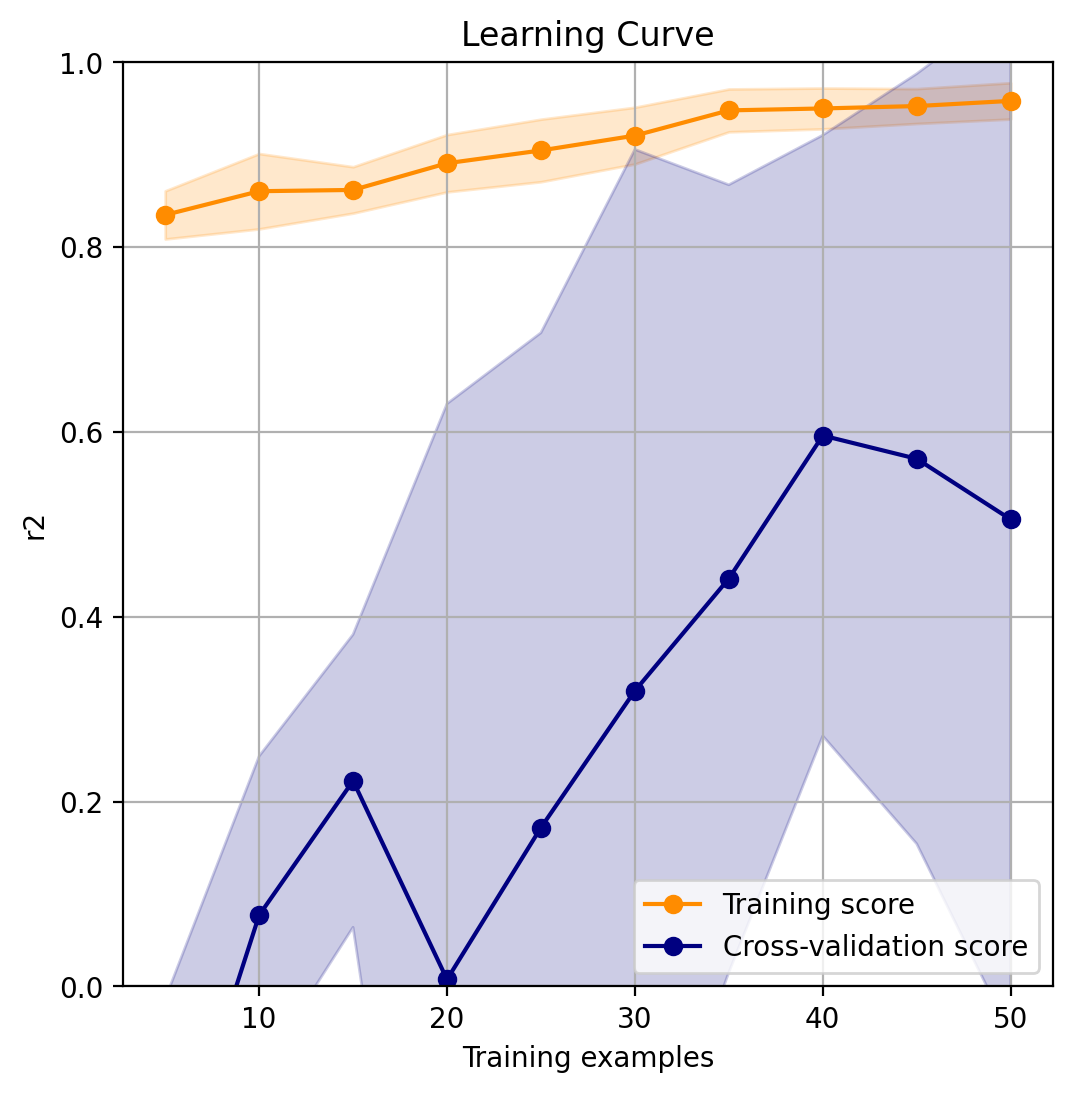

In [46]:
#building up learning curves


from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Define the model using the best parameters from GridSearch
model = RandomForestRegressor(**best_params, random_state=1401)

# Use the learning curve to get training and test scores

# scoring = 'neg_mean_squared_error'
scoring = 'r2'

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_final, Y_train, cv=5, scoring=scoring,
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, shuffle=True, random_state=1402)

# Calculate the mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate the mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(6, 6))
plt.plot(train_sizes, train_mean, label="Training score", color="darkorange", marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="darkorange", alpha=0.2)

plt.plot(train_sizes, test_mean, label="Cross-validation score", color="navy", marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="navy", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel(f"{scoring}")
plt.legend(loc="best")
plt.grid(True)
if scoring == 'r2':
    plt.ylim(0,1)
# if scoring == 'neg_mean_squared_error':
#     plt.yscale('log')
plt.show()


In [114]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import pickle
import os


n_splits = 5
n_trials = 500  

model_dir = 'saved_models_1'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

results = []


for seed in range(n_trials):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
    
    # Prepare data for scaling
    X_train_to_scale = X_train.drop(columns=already_scaled_features)
    X_train_already_scaled = X_train[already_scaled_features]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_to_scale)
    X_train_final = pd.concat([pd.DataFrame(X_train_scaled, columns=X_train_to_scale.columns, index=X_train_to_scale.index),
                               X_train_already_scaled], axis=1)

    # Initialize KFold and the RandomForestRegressor model
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    model = RandomForestRegressor(**best_params, random_state=seed)

    # Perform cross-validation and store scores and predictions
    scores = []
    mse_scores = []
    all_actual_fold = []
    all_predicted_fold = []
    for train_index, test_index in kf.split(X_train_final):
        X_fold_train, X_fold_test = X_train_final.iloc[train_index], X_train_final.iloc[test_index]
        Y_fold_train, Y_fold_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        model.fit(X_fold_train, Y_fold_train)
        Y_pred_fold = model.predict(X_fold_test)
        scores.append(r2_score(Y_fold_test, Y_pred_fold))
        mse_scores.append(mean_squared_error(Y_fold_test, Y_pred_fold))
        all_actual_fold.extend(Y_fold_test)
        all_predicted_fold.extend(Y_pred_fold)

    average_r2 = np.mean(scores)
    average_mse = np.mean(mse_scores)

    # Append results for this seed to the list
    results.append({'Seed': seed, 'R2_Score': average_r2, 'MSE': average_mse, 'Actual': all_actual_fold, 'Predicted': all_predicted_fold})

    # Save the model
    model_filename = os.path.join(model_dir, f'model_{seed}.pkl')
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)

# Convert list of results to DataFrame
results_df = pd.DataFrame(results)

# Save results DataFrame to a file
results_df.to_pickle("model_performance_results.pkl")


In [244]:
# import pickle

# # Load the model

# seed = 262
# model_filename = f'saved_models/model_{seed}.pkl'
# with open(model_filename, 'rb') as file:
#     model = pickle.load(file)


In [14]:
# results_df = results_df.sort_values(by='R2_Score', ascending=False)

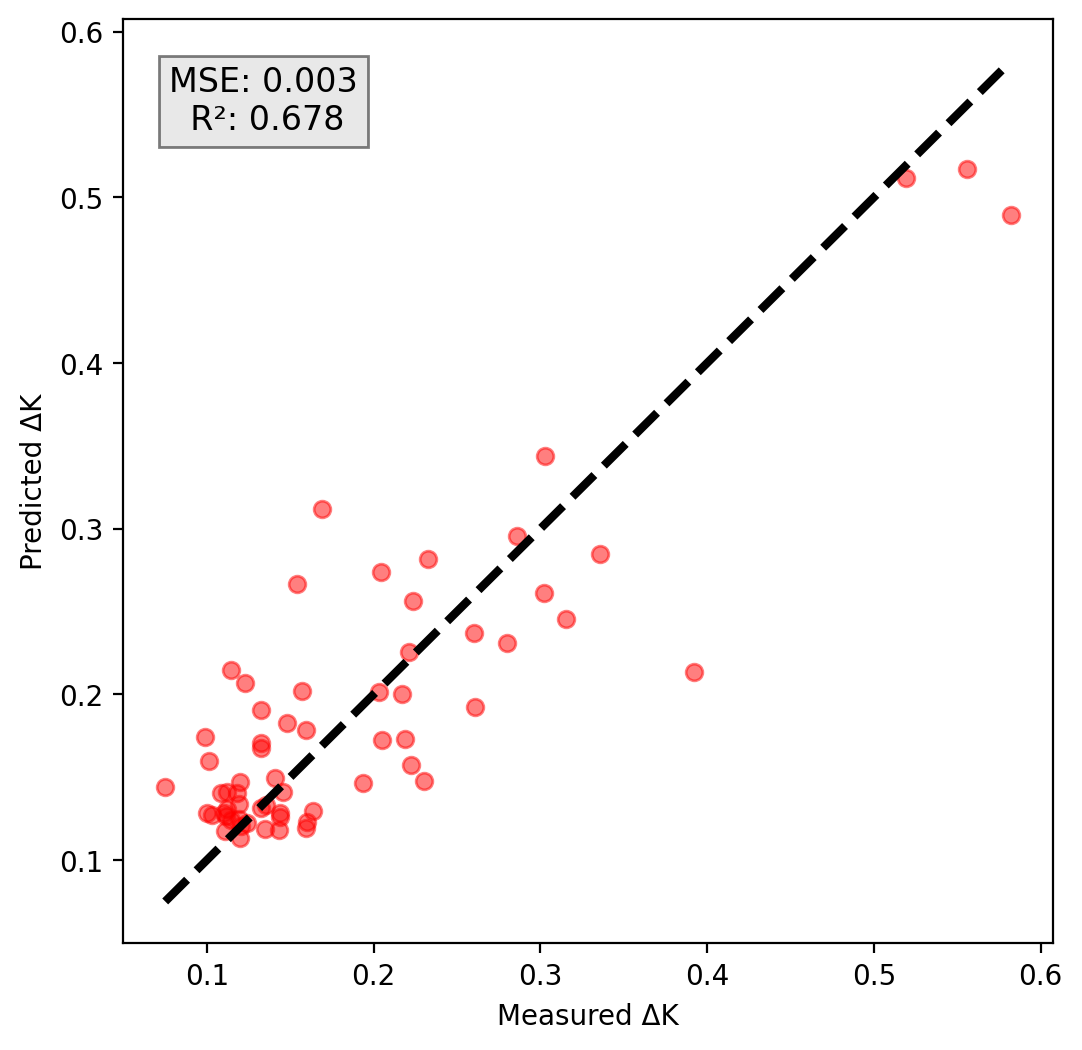

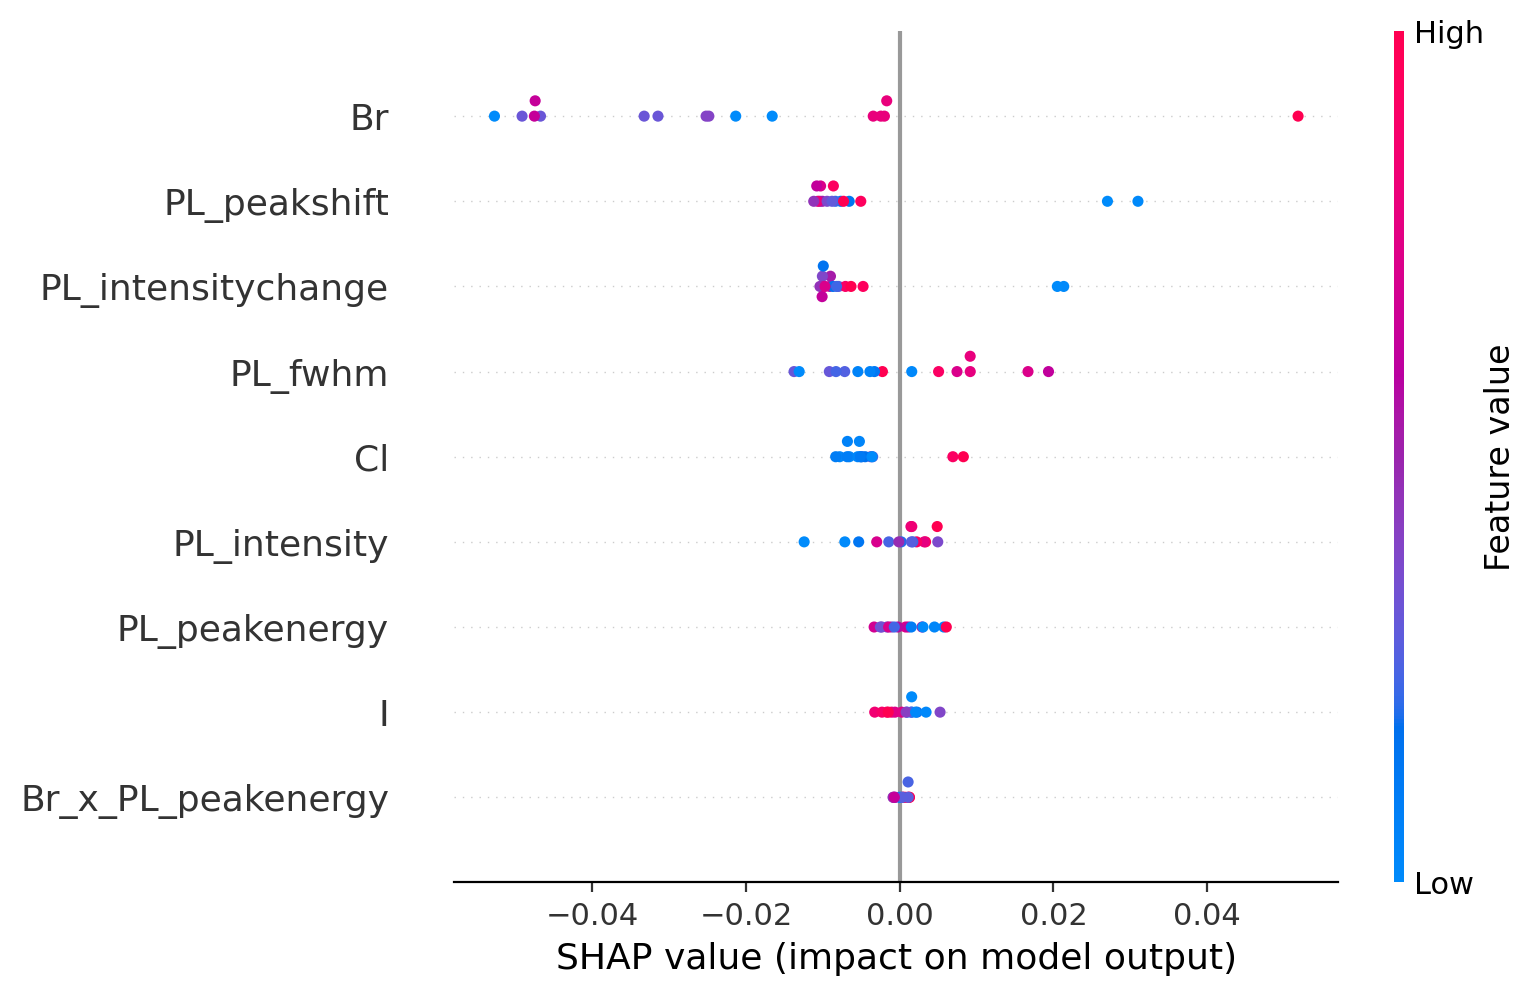

In [24]:
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import shap


seed = 157  # best
# seed = 368 #mode

results_df = pd.read_pickle("model_performance_results.pkl")
trial_data = results_df.loc[results_df['Seed'] == seed].iloc[0]


model_filename = f'saved_models/model_{seed}.pkl'
with open(model_filename, 'rb') as file:
    model = pickle.load(file)


# Plotting the parity plot
plt.figure(figsize=(6, 6))
plt.plot([min(trial_data['Actual']), max(trial_data['Actual'])], [min(trial_data['Actual']), max(trial_data['Actual'])], 'k--', lw=3)
plt.scatter(trial_data['Actual'], trial_data['Predicted'], alpha=.5, color='red')
plt.xlabel('Measured ΔK')
plt.ylabel('Predicted ΔK')
# plt.title('Parity Plot of Actual vs. Predicted Values')



trial_data = results_df.loc[results_df['Seed'] == seed].iloc[0]

# Extract actual values
actual_values = trial_data['Actual']

# NMSE normalized by variance
nmse_variance = np.round(trial_data['MSE'] / np.var(actual_values)*1e2,1)
print("NMSE normalized by variance:", nmse_variance, "%")

# Calculate RMSE
rmse = np.sqrt(trial_data['MSE'])

# Calculate the mean of actual values
mean_actual = np.mean(actual_values)

# Calculate CVRMSE
cvrmse = (rmse / mean_actual)
print("CVRMSE:", cvrmse, "%")











MSE = trial_data['MSE']
R2_Score = trial_data['R2_Score']




# Add the text for the metrics inside the plot
textstr = f'CVRMSE: {cvrmse:.3f}\n  R²: {R2_Score:.3f}'
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='square', facecolor='lightgray', alpha=0.5))

plt.show()



#shap addon
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

# # Prepare data for scaling
# X_train_to_scale = X_train.drop(columns=already_scaled_features)
# X_train_already_scaled = X_train[already_scaled_features]
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_to_scale)
# X_train_final = pd.concat([pd.DataFrame(X_train_scaled, columns=X_train_to_scale.columns, index=X_train_to_scale.index),
#                             X_train_already_scaled], axis=1)



# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test_final)
# shap.summary_plot(shap_values, X_test_final, feature_names=X_test.columns)


In [17]:
results_df = pd.read_pickle("/Users/deniz/Documents/GitHub/BODP/model_performance_results.pkl")

In [18]:
results_df.sort_values(by='R2_Score', ascending=False, inplace=True)

In [19]:
results_df

,Seed,R2_Score,MSE,Actual,Predicted
157,157,0.807643,0.001874,"[0.084111442, 0.22383062021578734, 0.111896379...","[0.18121143542273835, 0.26620455089292416, 0.1..."
274,274,0.807562,0.001666,"[0.11417159800029394, 0.1032574046117643, 0.58...","[0.12763478141520243, 0.11628741832769281, 0.4..."
462,462,0.800313,0.001738,"[0.30194450087962743, 0.1118963798496167, 0.26...","[0.2604663195256065, 0.14364660237429036, 0.20..."
464,464,0.799018,0.001755,"[0.20512883775981805, 0.0986327273805928, 0.31...","[0.17973545120012588, 0.14535464172625895, 0.2..."
398,398,0.794616,0.001802,"[0.1321631308543709, 0.2303712441721633, 0.218...","[0.1808334008621124, 0.17544009334936628, 0.19..."
...,...,...,...,...,...
382,382,-0.267300,0.003873,"[0.222131167464424, 0.1190557387845521, 0.1351...","[0.14692479351872456, 0.13259160837772904, 0.1..."
155,155,-0.288196,0.005311,"[0.1595696043227238, 0.1568689844949986, 0.222...","[0.20206528527681733, 0.19716981597191743, 0.1..."
91,91,-0.366941,0.004077,"[0.30194450087962743, 0.084111442, 0.153875078...","[0.2958567606997206, 0.1122021117971938, 0.121..."
130,130,-0.382774,0.004779,"[0.0749943627130564, 0.135109881929797, 0.1179...","[0.20308654170405616, 0.14509913623767912, 0.1..."


In [75]:
import kaleido
import plotly.offline as pyo


import pandas as pd
import plotly.graph_objects as go
import numpy as np

from IPython.core.display import display, HTML, Image
import plotly.io as pio
import base64

def display_save_button(fig):
    img_bytes = pio.to_image(fig, format='png', scale=1)
    img_b64 = base64.b64encode(img_bytes).decode('utf-8')
    
    button_html = """
    <img src="data:image/png;base64,{}"/>
    <button onclick="saveImage()">Save Image</button>
    <script>
        function saveImage() {{
            var link = document.createElement('a');
            link.href = 'data:image/png;base64,{}';
            link.download = 'plot.png';
            link.click();
        }}
    </script>
    """.format(img_b64, img_b64)
    
    display(HTML(button_html))



def coerce_to_numeric(df, col):
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(subset=[col], inplace=True)

def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df_filtered = df[~((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]
    return df_filtered, IQR

def plot_with_plotly(df, x_col, y_col, plot_high_res=False):
    fig = go.Figure()
    iqr_data = []

    if x_col is None:
        groups = [None]
        df[x_col] = ''  # Create a new column with a single label
    else:
        groups = df[x_col].unique()

    for batch in groups:
        df_batch = df if batch is None else df[df[x_col] == batch]
        df_batch_filtered, IQR = remove_outliers(df_batch, y_col)

        iqr_data.append({
            'Condition': batch if batch else '',
            'IQR': IQR
        })

        # Box Plot with full data
        fig.add_trace(go.Box(
            x=df_batch[x_col],
            y=df_batch[y_col],
            name=f"{batch} Box" if batch else "",
            line=dict(color='black'),
            fillcolor='rgba(0,0,0,0)',
            boxpoints='outliers'
        ))

        # Violin Plot with filtered data (no outliers)
        fig.add_trace(go.Violin(
            x=df_batch_filtered[x_col],
            y=df_batch_filtered[y_col],
            name=str(batch) if batch else "",
            box_visible=False,
            line_color='gray',
            fillcolor='rgba(0,0,0,0)',
            opacity=1,
            points='all',
            pointpos=0,
            jitter=0.5,
            marker=dict(
                color='gray',
                symbol='x'
            ),
        ))

    # Custom tick marks and x-axis line
    shapes = []
    
    #PL setting
    y_min = 0
    y_max = 1.1
    dy = .1
    y_label = 'R²'
    

    
    
    margin = 10
    tick_values = np.arange(y_min, y_max, dy)
    for tick in tick_values:
        shapes.append(
            dict(
                type='line',
                xref='paper',
                x0=-.01,
                x1=0,
                yref='y',
                y0=tick,
                y1=tick,
                line=dict(
                    color='black',
                    width=2
                )
            )
        )

    shapes.append(
        dict(
            type='line',
            xref='paper',
            x0=0,
            x1=1,
            yref='paper',
            y0=0,
            y1=0,
            line=dict(
                color='black',
                width=2,
                dash='dot'
            )
        )
    )
    
    fig.update_layout(
        plot_bgcolor='rgba(255,255,255,1)',
        paper_bgcolor='rgba(255,255,255,1)',
        xaxis=dict(
            showgrid=False,
            showline=False,
            linecolor='black'
        ),
        yaxis=dict(
            showgrid=True,
            showline=True,
            linecolor='black',
            tickvals=tick_values,
            ticktext=[f"{val:.1f}" for val in tick_values],
            tickprefix='  ',
            showticklabels=True,
            range=[y_min,y_max],
            tickfont=dict(
                size=30  # Change to your desired font size
            ),
        ),
        shapes=shapes,
        showlegend=False,
        width=500,
        height=600,
        margin=dict(
            l=margin,  # left margin
            r=margin,  # right margin
            b=margin,  # bottom margin
            t=margin   # top margin
        ),
        
        boxmode='group',  # group together boxes of the different traces for each value of x
        boxgap=0.1,  # gap between boxes of adjacent location coordinates
        boxgroupgap=0.0,  # gap between boxes of the same location coordinate
        violingap=0.1,  # gap between violins of adjacent location coordinates
        violingroupgap=0.0  # gap between violins of the same location coordinate

    )
    fig.update_yaxes(title_text=y_label,
                     title_font=dict(
                                size=30,  # Change to your desired font size
                                family="Arial, bold"  # Makes the title bold

    ))
    # pyo.plot(fig, image='png', image_filename='plot_image', auto_open=False)
    fig.show(scale=5)
    
    if plot_high_res:
        display_save_button(fig)


    return pd.DataFrame(iqr_data)

def analyze_and_plot(df, x_col, y_col, plot_high_res=False):
    coerce_to_numeric(df, y_col)
    iqr_df = plot_with_plotly(df, x_col, y_col, plot_high_res)
    return iqr_df

# Assuming metricdf_exp is your DataFrame
# Example usage:
iqr_result = analyze_and_plot(df, None, 'r2_scores_per_seed', plot_high_res=False)
print(iqr_result)


C:\Users\Deniz\AppData\Local\Temp\ipykernel_15956\3559621101.py:9: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



  Condition       IQR
0            0.228393


In [68]:
# r2_scores_per_seed
# # convert to df
# df = pd.DataFrame(r2_scores_per_seed, columns=['r2_scores_per_seed'])


In [22]:
# # Plotting the combined parity plotd
# plt.figure(figsize=(8, 8))
# plt.scatter(all_actual, all_predicted, alpha=0.3, color='blue')
# plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 'k--', lw=2)
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title(f'Combined Parity Plot')
# # plt.grid(True)
# plt.show()

# # Plotting the histogram of R² scores
# plt.figure(figsize=(6, 6))
# plt.hist(r2_scores_per_seed, bins=20, color='blue', edgecolor='black')
# plt.axvline(np.mean(r2_scores_per_seed), color='r', linestyle='--', label=f'Average R²: {np.mean(r2_scores_per_seed):.3f}')
# plt.xlabel('Average R² Score')
# plt.ylabel('Frequency')
# plt.xlim(0,1)
# plt.legend()
# plt.show()

Mode of R² scores (binned by 0.5%): 0.665 to 0.670
Count in mode bin: 12


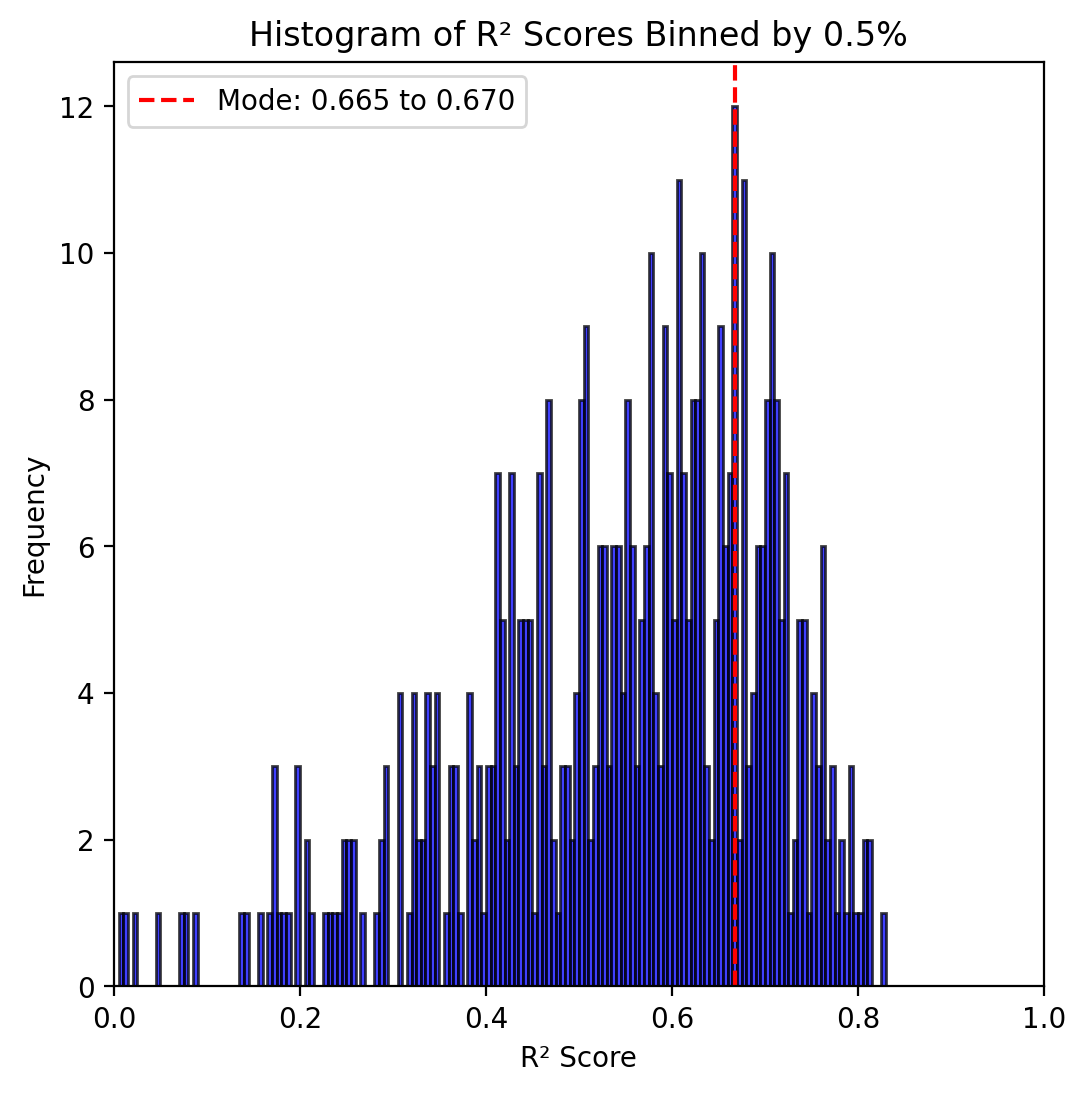

In [35]:
import numpy as np
from scipy.stats import mode

# Convert R2 scores to a categorical type based on bins of width 0.005
bin_width = 0.005
min_r2 = np.floor(min(r2_scores_per_seed) / bin_width) * bin_width
max_r2 = np.ceil(max(r2_scores_per_seed) / bin_width) * bin_width
bins = np.arange(min_r2, max_r2 + bin_width, bin_width)
r2_scores_binned = np.digitize(r2_scores_per_seed, bins) - 1  # Get bin indices

# Count frequencies in each bin
bin_counts = np.bincount(r2_scores_binned)
most_frequent_bin = np.argmax(bin_counts)

# Determine the mode as the bin with the highest count
mode_r2_value = bins[most_frequent_bin]
mode_r2_count = bin_counts[most_frequent_bin]

print(f"Mode of R² scores (binned by 0.5%): {mode_r2_value:.3f} to {mode_r2_value + bin_width:.3f}")
print(f"Count in mode bin: {mode_r2_count}")

# Optionally, plot the histogram with these bins
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.hist(r2_scores_per_seed, bins=bins, color='blue', edgecolor='black', alpha=0.75)
plt.axvline(mode_r2_value + bin_width / 2, color='r', linestyle='--', label=f'Mode: {mode_r2_value:.3f} to {mode_r2_value + bin_width:.3f}')
plt.xlabel('R² Score')
plt.ylabel('Frequency')
plt.title('Histogram of R² Scores Binned by 0.5%')
plt.xlim(0,1)
plt.legend()
plt.show()
